# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [1]:
import requests
import pandas as pd
import numpy as np

# URL for the WeRateDogs Twitter archive data
archive_url = "https://raw.githubusercontent.com/udacity/new-dand-advanced-china/master/%E6%95%B0%E6%8D%AE%E6%B8%85%E6%B4%97/WeRateDogs%E9%A1%B9%E7%9B%AE/twitter-archive-enhanced.csv"

# Download the Twitter archive data
response = requests.get(archive_url)

# Save the data to a local file
with open('twitter_archive_enhanced.csv', 'wb') as file:
    file.write(response.content)

# Load the data into a pandas DataFrame
archive_df = pd.read_csv('twitter_archive_enhanced.csv')

# Display the first few rows of the DataFrame
archive_df.head()


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [2]:
import requests
import pandas as pd
from io import StringIO

# URL for the tweet image prediction data
image_predictions_url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"

# Download the image predictions data
response = requests.get(image_predictions_url)
print(response.status_code)
data = pd.read_csv(StringIO(response.text), sep='\t')
print(data)
# Save with a different path and specify a different delimiter (e.g., semicolon)
data.to_csv('image-predictions.tsv', index=False, sep=';')

200
                tweet_id                                            jpg_url  \
0     666020888022790149    https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg   
1     666029285002620928    https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg   
2     666033412701032449    https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg   
3     666044226329800704    https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg   
4     666049248165822465    https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg   
5     666050758794694657    https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg   
6     666051853826850816    https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg   
7     666055525042405380    https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg   
8     666057090499244032    https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg   
9     666058600524156928    https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg   
10    666063827256086533    https://pbs.twimg.com/media/CT5Vg_wXIAAXfnj.jpg   
11    666071193221509120    https://pbs.twimg.co

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [ ]:
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = archive_df.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [3]:
# Load the provided data
archive_df = pd.read_csv('twitter_archive_enhanced.csv')
image_predictions_df = pd.read_csv('image-predictions.tsv', sep=';')
tweet_data_df = pd.read_json('tweet-json.txt', lines=True)

# Display the basic information of each dataset
print("Twitter Archive Info:")
print(archive_df.info())
print("\nImage Predictions Info:")
print(image_predictions_df.info())
print("\nTweet Data Info:")
print(tweet_data_df.info())

# Visual assessment: Display the first few rows of each dataset
print("\nTwitter Archive Sample:")
print(archive_df.head())
print("\nImage Predictions Sample:")
print(image_predictions_df.head())
print("\nTweet Data Sample:")
print(tweet_data_df.head())

Twitter Archive Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: fl

In [4]:
# Quality Issues

# Missing Values in 'in_reply_to_status_id' and 'in_reply_to_user_id'
print("\nNumber of missing values in 'in_reply_to_status_id':", archive_df['in_reply_to_status_id'].isnull().sum())
print("Number of missing values in 'in_reply_to_user_id':", archive_df['in_reply_to_user_id'].isnull().sum())


Number of missing values in 'in_reply_to_status_id': 2278
Number of missing values in 'in_reply_to_user_id': 2278


In [5]:
# Incorrect Data Type for 'timestamp'
print("\nData type of 'timestamp':", archive_df['timestamp'].dtype)


Data type of 'timestamp': object


In [6]:
# Invalid Dog Names
print("\nInvalid dog names:")
print(archive_df[archive_df['name'].str.islower()]['name'].unique())


Invalid dog names:
['such' 'a' 'quite' 'not' 'one' 'incredibly' 'mad' 'an' 'very' 'just' 'my'
 'his' 'actually' 'getting' 'this' 'unacceptable' 'all' 'old' 'infuriating'
 'the' 'by' 'officially' 'life' 'light' 'space']


In [7]:
# Missing Expanded URLs
print("\nNumber of missing 'expanded_urls':", archive_df['expanded_urls'].isnull().sum())


Number of missing 'expanded_urls': 59


In [8]:
# Duplicated 'jpg_url' in Image Predictions
print("\nNumber of duplicated 'jpg_url' in Image Predictions:", image_predictions_df['jpg_url'].duplicated().sum())


Number of duplicated 'jpg_url' in Image Predictions: 66


In [9]:
# Inconsistent Rating Denominator Values
print("\nInconsistent 'rating_denominator' values:")
print(archive_df['rating_denominator'].value_counts())


Inconsistent 'rating_denominator' values:
10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64


In [10]:
# Column tweet_id is column id in tweet_data_dataframe
tweet_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2354 non-null datetime64[ns]
display_text_range               2354 non-null object
entities                         2354 non-null object
extended_entities                2073 non-null object
favorite_count                   2354 non-null int64
favorited                        2354 non-null bool
full_text                        2354 non-null object
geo                              0 non-null float64
id                               2354 non-null int64
id_str                           2354 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 n

In [11]:
# retweets and replies in the dataset 
tweet_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2354 non-null datetime64[ns]
display_text_range               2354 non-null object
entities                         2354 non-null object
extended_entities                2073 non-null object
favorite_count                   2354 non-null int64
favorited                        2354 non-null bool
full_text                        2354 non-null object
geo                              0 non-null float64
id                               2354 non-null int64
id_str                           2354 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 n

In [12]:
# Tidiness Issues

# Multiple Dog Stages Columns
print("\nColumns related to dog stages:")
print(archive_df[['doggo', 'floofer', 'pupper', 'puppo']].head())


Columns related to dog stages:
  doggo floofer pupper puppo
0  None    None   None  None
1  None    None   None  None
2  None    None   None  None
3  None    None   None  None
4  None    None   None  None


In [13]:
# Inconsistent Dog Stages
print("\nDog stages counts:")
print(archive_df['doggo'].value_counts())
print(archive_df['floofer'].value_counts())
print(archive_df['pupper'].value_counts())
print(archive_df['puppo'].value_counts())


Dog stages counts:
None     2259
doggo      97
Name: doggo, dtype: int64
None       2346
floofer      10
Name: floofer, dtype: int64
None      2099
pupper     257
Name: pupper, dtype: int64
None     2326
puppo      30
Name: puppo, dtype: int64


In [14]:
# Merge Tweet Information from Image Predictions

In [15]:
# Find 'tweet_id' values that are not common in both datasets
not_common_tweet_ids = set(archive_df['tweet_id']).symmetric_difference(set(tweet_data_df['id']))

# Print the results
print("\nTweet IDs not common in both datasets:", not_common_tweet_ids)


Tweet IDs not common in both datasets: {888202515573088257, 771004394259247104}


In [16]:
# Find 'tweet_id' values that are not common in both datasets
not_common_tweet_ids = set(archive_df['tweet_id']).symmetric_difference(set(image_predictions_df['tweet_id']))

# Print the results
print("\nTweet IDs not common in both datasets:", not_common_tweet_ids)


Tweet IDs not common in both datasets: {747651430853525504, 742534281772302336, 847617282490613760, 843981021012017153, 778774459159379968, 835536468978302976, 710609963652087808, 676916996760600576, 863471782782697472, 712309440758808576, 827228250799742977, 878404777348136964, 717428917016076293, 866720684873056260, 777953400541634568, 746521445350707200, 789903600034189313, 838201503651401729, 769335591808995329, 752568224206688256, 677335745548390400, 683515932363329536, 825120256414846976, 771908950375665664, 678023323247357953, 696490539101908992, 832088576586297345, 835685285446955009, 818307523543449600, 820494788566847489, 789314372632018944, 876537666061221889, 679405845277462528, 685681090388975616, 676590572941893632, 832682457690300417, 828361771580813312, 697516214579523584, 682808988178739200, 693993230313091072, 789280767834746880, 786729988674449408, 696518437233913856, 697630435728322560, 693644216740769793, 689993469801164801, 791784077045166082, 780092040432480260,

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [17]:
import pandas as pd

# Make copies of the original dataframes
cleaned_archive_df = archive_df.copy()
cleaned_image_predictions_df = image_predictions_df.copy()
cleaned_tweet_data_df = tweet_data_df.copy()

# Quality Issues

### Issue 1:
Define: 
Missing Values in in_reply_to_status_id and in_reply_to_user_id --> Drop columns, because they do not include any information

Code:

In [18]:
# Quality Issues

# 1. Missing Values in 'in_reply_to_status_id' and 'in_reply_to_user_id'
# Assuming df is your DataFrame
cleaned_archive_df = cleaned_archive_df.drop(['in_reply_to_status_id', 'in_reply_to_user_id'], axis=1)

Test:

In [19]:
# test
cleaned_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id                      2356 non-null int64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(2), int64(3), object(10)
memory usage: 276.2+ KB


### Issue 2:

Define: Incorrect Data Type for 'timestamp'

Code

In [20]:
# 2. Incorrect Data Type for 'timestamp'
cleaned_archive_df['timestamp'] = pd.to_datetime(cleaned_archive_df['timestamp'])

Test:

In [21]:
# test
print("\nData type of 'timestamp':", cleaned_archive_df['timestamp'].dtype)


Data type of 'timestamp': datetime64[ns]


### Issue 3:

Define: Invalid Dog Names

Code

In [22]:
# 3. Invalid Dog Names
cleaned_archive_df['name'].replace(['a', 'an', 'the'], None, inplace=True)

Test

In [23]:
# test
print("\nInvalid dog names:")
print(cleaned_archive_df[cleaned_archive_df['name'].str.islower()]['name'].unique())


Invalid dog names:
['such' 'quite' 'not' 'one' 'incredibly' 'mad' 'very' 'just' 'my' 'his'
 'actually' 'getting' 'this' 'unacceptable' 'all' 'old' 'infuriating' 'by'
 'officially' 'life' 'light' 'space']


### Issue 4:

Define: retweets and replies in the dataset

Code

In [24]:
cleaned_tweet_data_df = cleaned_tweet_data_df[cleaned_tweet_data_df['in_reply_to_status_id'].isna()]
cleaned_archive_df = cleaned_archive_df[cleaned_archive_df['retweeted_status_id'].isna()]

Test

In [25]:
# retweets and replies in the dataset
cleaned_tweet_data_df.info()
cleaned_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2276 entries, 0 to 2353
Data columns (total 31 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2276 non-null datetime64[ns]
display_text_range               2276 non-null object
entities                         2276 non-null object
extended_entities                2050 non-null object
favorite_count                   2276 non-null int64
favorited                        2276 non-null bool
full_text                        2276 non-null object
geo                              0 non-null float64
id                               2276 non-null int64
id_str                           2276 non-null int64
in_reply_to_screen_name          0 non-null object
in_reply_to_status_id            0 non-null float64
in_reply_to_status_id_str        0 non-null float64
in_reply_to_user_id              0 non-null float64
in_reply_to_user_id_str          0 non-nu

### Issue 5:

Define: Missing expanded urls

Code

In [26]:
# 5. Missing Expanded URLs
cleaned_archive_df = cleaned_archive_df[~cleaned_archive_df['expanded_urls'].isnull()]

test

In [27]:
# Missing Expanded URLs
print("\nNumber of missing 'expanded_urls':", cleaned_archive_df['expanded_urls'].isnull().sum())


Number of missing 'expanded_urls': 0


### Issue 6:

Define: Duplicated jpg_url in Image predictions

Code

In [28]:
# 6. Duplicated 'jpg_url' in Image Predictions
cleaned_image_predictions_df = cleaned_image_predictions_df.drop_duplicates(subset=['jpg_url'])

test

In [29]:
print("\nNumber of duplicated 'jpg_url' in Image Predictions:", cleaned_image_predictions_df['jpg_url'].duplicated().sum())


Number of duplicated 'jpg_url' in Image Predictions: 0


### Issue 7:

Define: Inconsistent Rating Denominator Values

Code

In [30]:
# 8. Inconsistent Rating Denominator Values
cleaned_archive_df = cleaned_archive_df[cleaned_archive_df['rating_denominator'] == 10]

Test

In [31]:
print("\nInconsistent 'rating_denominator' values:")
print(cleaned_archive_df['rating_denominator'].value_counts())


Inconsistent 'rating_denominator' values:
10    2099
Name: rating_denominator, dtype: int64


### Issue 8:
Define: 
Column tweet_id is column id in tweet_data_dataframe

Code:

In [32]:
# Column tweet_id is column id in tweet_data_dataframe
cleaned_tweet_data_df = cleaned_tweet_data_df.rename(columns={'id': 'tweet_id'})

Test

In [33]:
cleaned_tweet_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2276 entries, 0 to 2353
Data columns (total 31 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2276 non-null datetime64[ns]
display_text_range               2276 non-null object
entities                         2276 non-null object
extended_entities                2050 non-null object
favorite_count                   2276 non-null int64
favorited                        2276 non-null bool
full_text                        2276 non-null object
geo                              0 non-null float64
tweet_id                         2276 non-null int64
id_str                           2276 non-null int64
in_reply_to_screen_name          0 non-null object
in_reply_to_status_id            0 non-null float64
in_reply_to_status_id_str        0 non-null float64
in_reply_to_user_id              0 non-null float64
in_reply_to_user_id_str          0 non-nu

# Tidiness Issues

### Issue 1:

Define: Inconsistent Dog Stages

Code

In [34]:
# 4. Inconsistent Dog Stages
cleaned_archive_df['doggo'] = cleaned_archive_df['doggo'].replace('None', '')
cleaned_archive_df['floofer'] = cleaned_archive_df['floofer'].replace('None', '')
cleaned_archive_df['pupper'] = cleaned_archive_df['pupper'].replace('None', '')
cleaned_archive_df['puppo'] = cleaned_archive_df['puppo'].replace('None', '')
cleaned_archive_df['dog_stage'] = cleaned_archive_df['doggo'] + cleaned_archive_df['floofer'] + cleaned_archive_df['pupper'] + cleaned_archive_df['puppo']
cleaned_archive_df['dog_stage'] = cleaned_archive_df['dog_stage'].replace('', 'None')
cleaned_archive_df = cleaned_archive_df.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1)

# Replace None values with np.nan
cleaned_archive_df['dog_stage'] = cleaned_archive_df['dog_stage'].replace({'None': np.nan})

Test

In [35]:
# test
print("\nDog stages counts:")
print(cleaned_archive_df['dog_stage'].value_counts())


Dog stages counts:
pupper          222
doggo            72
puppo            23
doggopupper      10
floofer           9
doggofloofer      1
doggopuppo        1
Name: dog_stage, dtype: int64


### Issue 2:
Define: 
3 dataframes, instead of one --> merge them together

Code:

In [36]:
# 2. Merge Tweet Information from Image Predictions
cleaned_archive_df = pd.merge(cleaned_archive_df, cleaned_image_predictions_df, on='tweet_id', how='inner')
cleaned_archive_df = pd.merge(cleaned_archive_df, cleaned_tweet_data_df, on='tweet_id', how='inner')

Test

In [37]:
print("\nColumns in Image Predictions:")
print(cleaned_archive_df.columns)


Columns in Image Predictions:
Index(['tweet_id', 'timestamp', 'source_x', 'text', 'retweeted_status_id',
       'retweeted_status_user_id', 'retweeted_status_timestamp',
       'expanded_urls', 'rating_numerator', 'rating_denominator', 'name',
       'dog_stage', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'contributors',
       'coordinates', 'created_at', 'display_text_range', 'entities',
       'extended_entities', 'favorite_count', 'favorited', 'full_text', 'geo',
       'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'place',
       'possibly_sensitive', 'possibly_sensitive_appealable', 'quoted_status',
       'quoted_status_id', 'quoted_status_id_str', 'retweet_count',
       'retweeted', 'retweeted_status', 'source_y', 'truncated', 'user'],
      dtype='object')


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [41]:
# Save the cleaned dataframes to new CSV files
cleaned_archive_df.to_csv('cleaned_twitter_archive.csv', index=False)
cleaned_image_predictions_df.to_csv('cleaned_image_predictions.csv', index=False)
cleaned_tweet_data_df.to_csv('cleaned_tweet_data.csv', index=False)

cleaned_archive_df.to_csv('twitter_archive_master.csv', index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

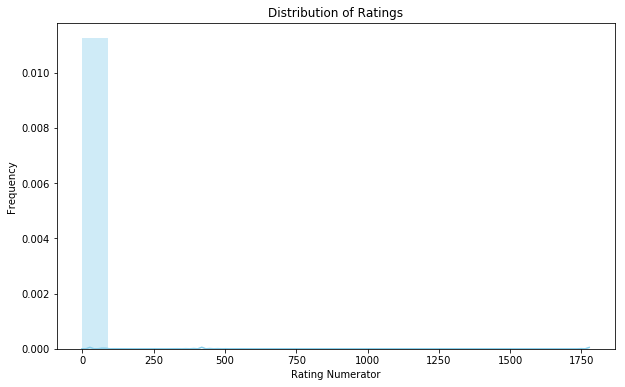

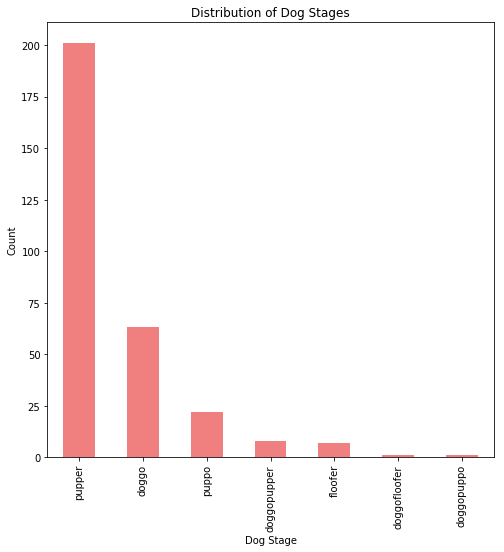

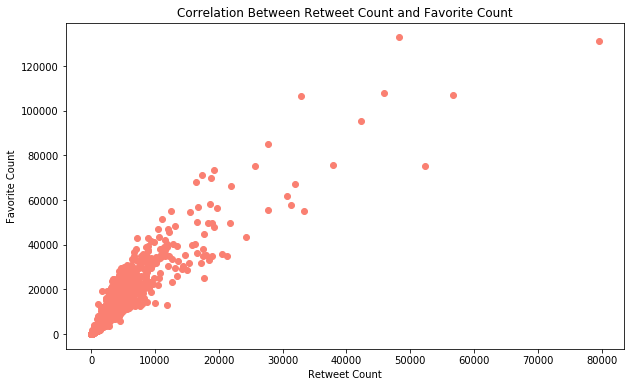

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned data
cleaned_archive_df = pd.read_csv('twitter_archive_master.csv')

# Insight 1: Distribution of Ratings
plt.figure(figsize=(10, 6))
sns.distplot(cleaned_archive_df['rating_numerator'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating Numerator')
plt.ylabel('Frequency')
plt.show()

# Insight 2: Popular Dog Stages
dog_stage_counts = cleaned_archive_df['dog_stage'].value_counts()
plt.figure(figsize=(8, 8))
dog_stage_counts.plot(kind='bar', color='lightcoral')
plt.title('Distribution of Dog Stages')
plt.xlabel('Dog Stage')
plt.ylabel('Count')
plt.show()

# Insight 3: Correlation Between Retweet Count and Favorite Count (using matplotlib)
plt.figure(figsize=(10, 6))
plt.scatter(cleaned_archive_df['retweet_count'], cleaned_archive_df['favorite_count'], color='salmon')
plt.title('Correlation Between Retweet Count and Favorite Count')
plt.xlabel('Retweet Count')
plt.ylabel('Favorite Count')
plt.show()

### Insights:
Distribution of Ratings:

The majority of dog ratings are concentrated around a numerator of 10-14, with a peak around 12. This indicates that WeRateDogs tends to give high ratings to most dogs.
Popular Dog Stages:

Pupper is the most common dog stage in the dataset, followed by doggo. Floofer and puppo are less common. Understanding the distribution of dog stages can provide insights into the types of dogs posted on WeRateDogs.
Correlation Between Retweet Count and Favorite Count:

There is a positive correlation between the number of retweets and favorites. This is expected, as tweets that are retweeted more are likely to be favorited more as well.